<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Analysis/2021_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U gensim
!pip install pyLDAvis
!pip install shap
!pip install datasets

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud
import pprint

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction                      
import IPython

from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import shap
import datasets

     |████████████████████████████████| 24.1 MB 16.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=61f7bb1254f8fd772359cdcb702ba65ebc45bec84992758b96b2ac6cf842228c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
     |████████████████████████████████| 564 kB 5.1 MB/s 
     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 212 kB 47.8 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████|

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` t

# Loading and cleaning data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  LDA_HetParool.png	LDA_Trouw.png
LDA_all.html	     LDA__.html		LDA_Volkskrant.html
LDA_All.html	     LDA_NRC.html	NRC_2021.json
LDA_all.png	     LDA_NRC.png	Telegraaf_2021.json
LDA_All.png	     LDA__.png		Trouw_2021.json
LDA_HetParool.html   LDA_Trouw.html	Volkskrant_2021.json


In [4]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

In [5]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

In [6]:
df_NRC["Source"] = "NRC"
df_Trouw["Source"] = "Trouw"
df_HetParool["Source"] = "HetParool"
df_Telegraaf["Source"] = "Telegraaf"
df_Volkskrant["Source"] = "Volkskrant"

In [7]:
print(df_NRC.shape)
print(df_Trouw.shape)
print(df_HetParool.shape)
print(df_Volkskrant.shape)

(38334, 7)
(21077, 7)
(18551, 7)
(25773, 7)


## Concat data

In [8]:

dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Source
0,https://www.nrc.nl/nieuws/2021/01/31/een-herha...,2021-01-31 20:18:43,Een herhaling van vorig seizoen is zo goed als...,Fabian van der Poll,De eerste maand van 2021 is uitstekend verlope...,None,NRC
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC
2,https://www.nrc.nl/nieuws/2021/01/31/school-op...,2021-01-31 19:58:21,"School open? Dan testen, ventilatie en mondkapjes",Karel Berkhout,Door de heropening van de scholen loopt het aa...,None,NRC
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC
4,https://www.nrc.nl/nieuws/2021/01/31/arrestati...,2021-01-31 19:43:49,Arrestatie Russische betoger,None,,None,NRC


## Remove missing text

In [9]:
df = df[df['cleantext'].str.len()>5]
print(df.shape)

(96840, 7)


# Word2vec

In [10]:
def tsne_analysis(df):
  articles = df.drop(columns=['url', 'publisherID', 'category',], axis=1)
  articles = articles[articles['cleantext'].notna()]
  # Remove punctuation
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
  # Save D66
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
  # Save BIJ1
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
  # Save 50PLUS
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
  # Save JA21
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
  # Convert the titles to lowercase
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

  p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
              'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
              'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
              'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
              'simons', 'den haan']

  pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
  articles = articles[articles['cleantext_processed'].str.contains(pat)]

  corpus = list(articles["cleantext_processed"].values)
  corp_length = len(corpus)

  print("Frame shape: ", articles.shape)
  print("Corpus length: ", len(corpus))

  class Corpus():
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, corpus):
      self.corpus = corpus

    def __iter__(self):
        for line in self.corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

  # Training full corpus 60 hours
  sentences = Corpus(corpus)
  model = gensim.models.Word2Vec(sentences=tqdm(sentences, total=corp_length))

  def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, verbose=1)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


  return reduce_dimensions(model)



In [46]:
x_vals, y_vals, labels = tsne_analysis(df)

Frame shape:  (15498, 5)
Corpus length:  15498


100%|██████████| 15498/15498 [00:18<00:00, 821.97it/s]
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 49213 samples in 0.005s...
[t-SNE] Computed neighbors for 49213 samples in 70.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 49213
[t-SNE] Computed conditional probabilities for sample 2000 / 49213
[t-SNE] Computed conditional probabilities for sample 3000 / 49213
[t-SNE] Computed conditional probabilities for sample 4000 / 49213
[t-SNE] Computed conditional probabilities for sample 5000 / 49213
[t-SNE] Computed conditional probabilities for sample 6000 / 49213
[t-SNE] Computed conditional probabilities for sample 7000 / 49213
[t-SNE] Computed conditional probabilities for sample 8000 / 49213
[t-SNE] Computed conditional probabilities for sample 9000 / 49213
[t-SNE] Computed conditional probabilities for sample 10000 / 49213
[t-SNE] Computed conditional probabilities for sample 11000 / 49213
[t-SNE] Computed conditional probabilities for sample 12000 / 49213
[t-SNE] Computed conditional probabilities for sa

In [47]:
def plot_with_matplotlib(x_vals, y_vals, labels, terms):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(16, 16))
    #plt.scatter(x_vals, y_vals)

    #
    # Label data points
    #
    selected_indices =[]
    parties = terms

    for p in parties:
      selected_indices.append(list(labels).index(p))
    
    for i in selected_indices:
      plt.scatter(x_vals[i], y_vals[i])
      plt.annotate(labels[i], (x_vals[i], y_vals[i]))

    plt.legend(terms)

In [48]:
parties = ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
            'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'vluchtelingen']

pols = ['rutte', 'kaag', 'wilders', 'hoekstra', 'ploumen', 'marijnissen',
 'klaver', 'baudet', 'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas', 'simons', 'vluchtelingen']

plot_function = plot_with_matplotlib

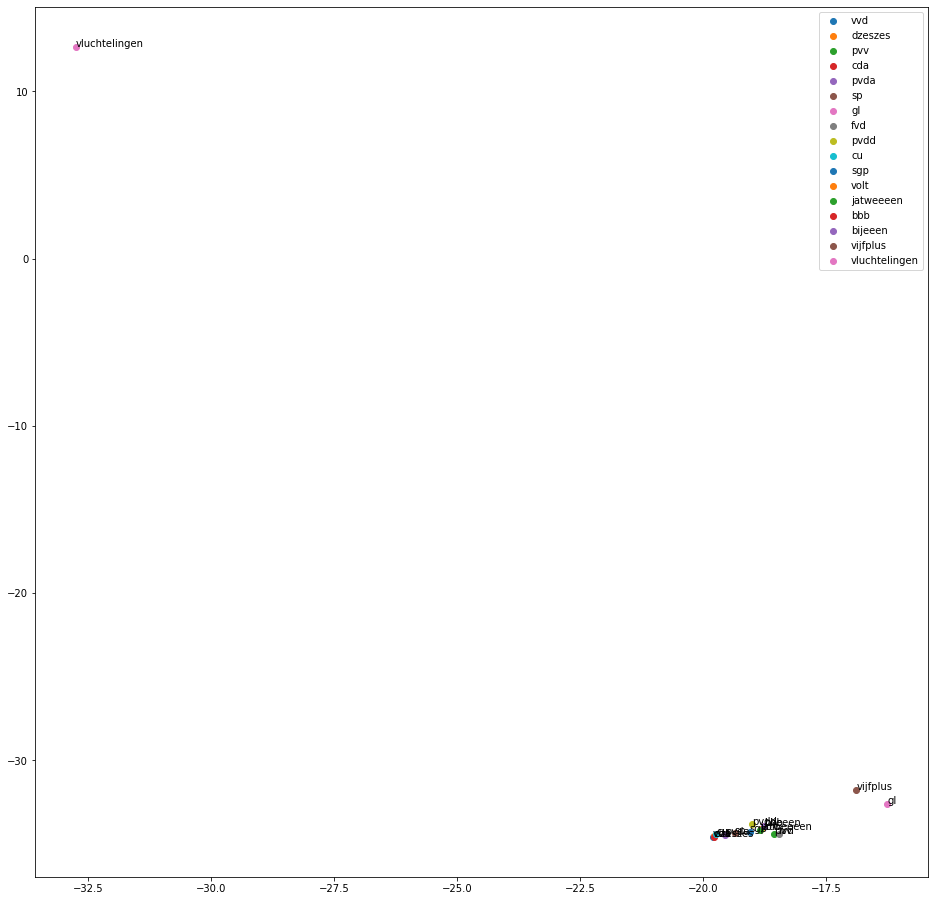

In [49]:
plot_function(x_vals, y_vals, labels, parties)

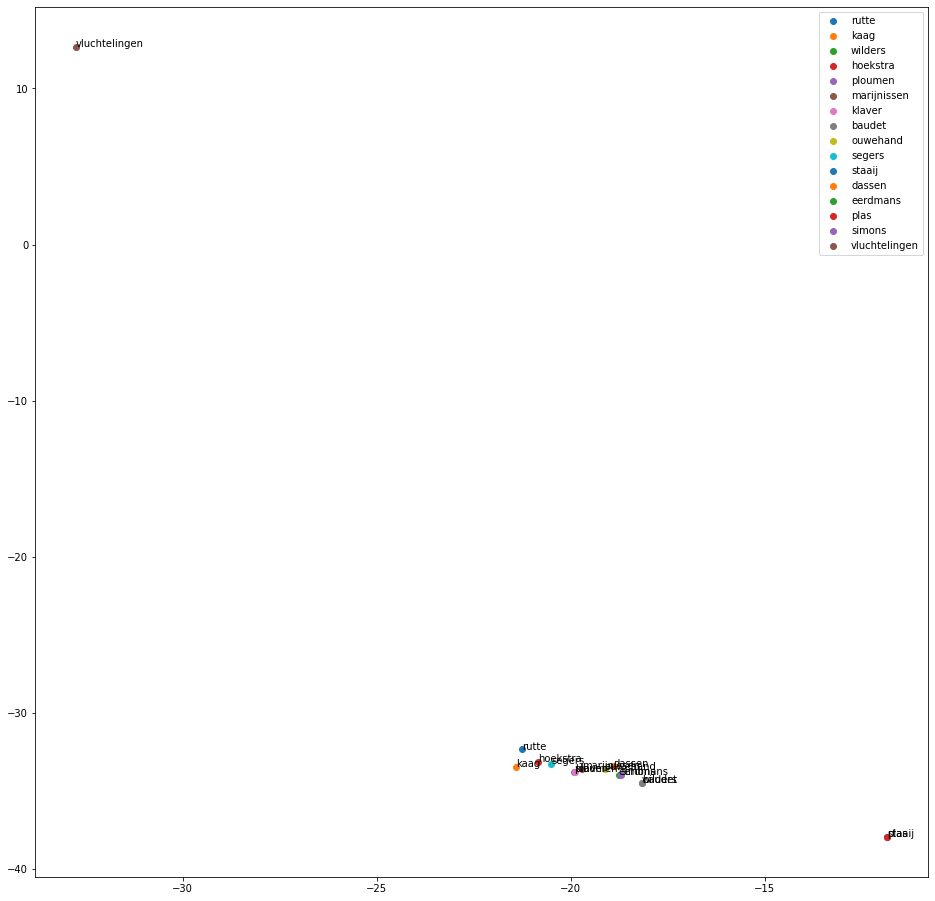

In [50]:
plot_function(x_vals, y_vals, labels, pols)

In [36]:
x_vals, y_vals, labels = tsne_analysis(df_NRC)

Frame shape:  (6423, 5)
Corpus length:  6423


100%|██████████| 6423/6423 [00:08<00:00, 801.33it/s]
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 29326 samples in 0.003s...
[t-SNE] Computed neighbors for 29326 samples in 26.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29326
[t-SNE] Computed conditional probabilities for sample 2000 / 29326
[t-SNE] Computed conditional probabilities for sample 3000 / 29326
[t-SNE] Computed conditional probabilities for sample 4000 / 29326
[t-SNE] Computed conditional probabilities for sample 5000 / 29326
[t-SNE] Computed conditional probabilities for sample 6000 / 29326
[t-SNE] Computed conditional probabilities for sample 7000 / 29326
[t-SNE] Computed conditional probabilities for sample 8000 / 29326
[t-SNE] Computed conditional probabilities for sample 9000 / 29326
[t-SNE] Computed conditional probabilities for sample 10000 / 29326
[t-SNE] Computed conditional probabilities for sample 11000 / 29326
[t-SNE] Computed conditional probabilities for sample 12000 / 29326
[t-SNE] Computed conditional probabilities for sa

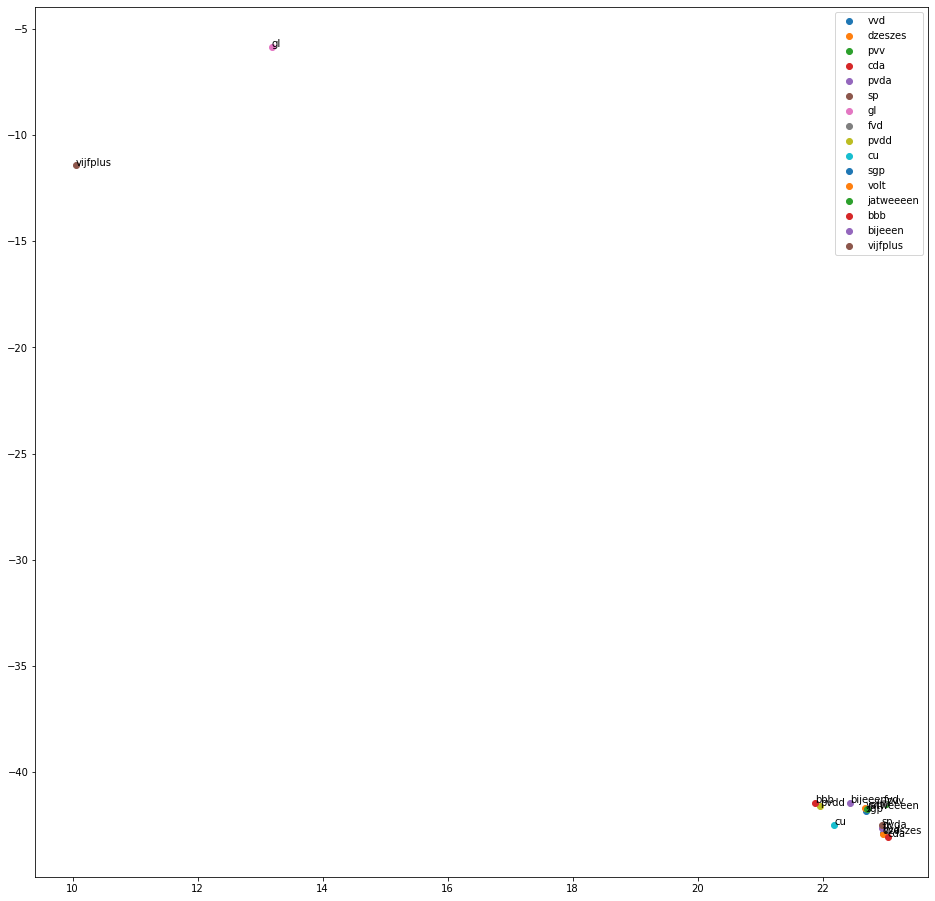

In [37]:
plot_function(x_vals, y_vals, labels, parties)

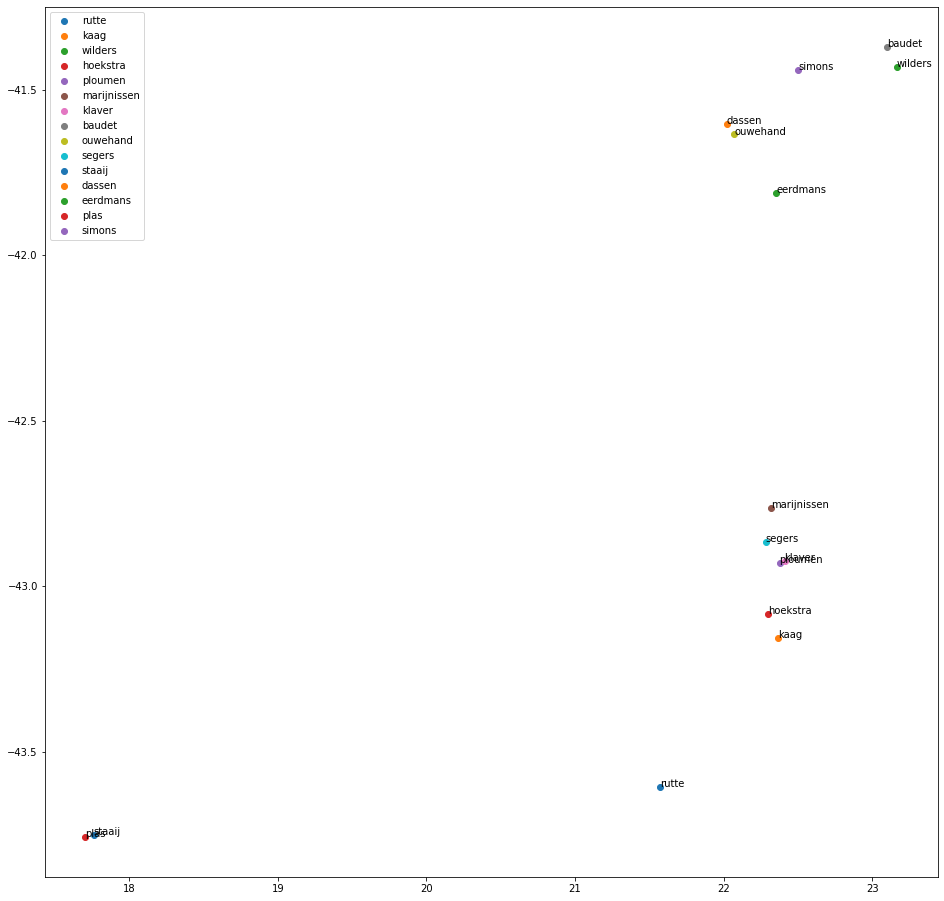

In [38]:
plot_function(x_vals, y_vals, labels, pols)

In [39]:
x_vals, y_vals, labels = tsne_analysis(df_Trouw)

Frame shape:  (2874, 5)
Corpus length:  2874


100%|██████████| 2874/2874 [00:03<00:00, 931.89it/s]
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16954 samples in 0.002s...
[t-SNE] Computed neighbors for 16954 samples in 9.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16954
[t-SNE] Computed conditional probabilities for sample 2000 / 16954
[t-SNE] Computed conditional probabilities for sample 3000 / 16954
[t-SNE] Computed conditional probabilities for sample 4000 / 16954
[t-SNE] Computed conditional probabilities for sample 5000 / 16954
[t-SNE] Computed conditional probabilities for sample 6000 / 16954
[t-SNE] Computed conditional probabilities for sample 7000 / 16954
[t-SNE] Computed conditional probabilities for sample 8000 / 16954
[t-SNE] Computed conditional probabilities for sample 9000 / 16954
[t-SNE] Computed conditional probabilities for sample 10000 / 16954
[t-SNE] Computed conditional probabilities for sample 11000 / 16954
[t-SNE] Computed conditional probabilities for sample 12000 / 16954
[t-SNE] Computed conditional probabilities for sam

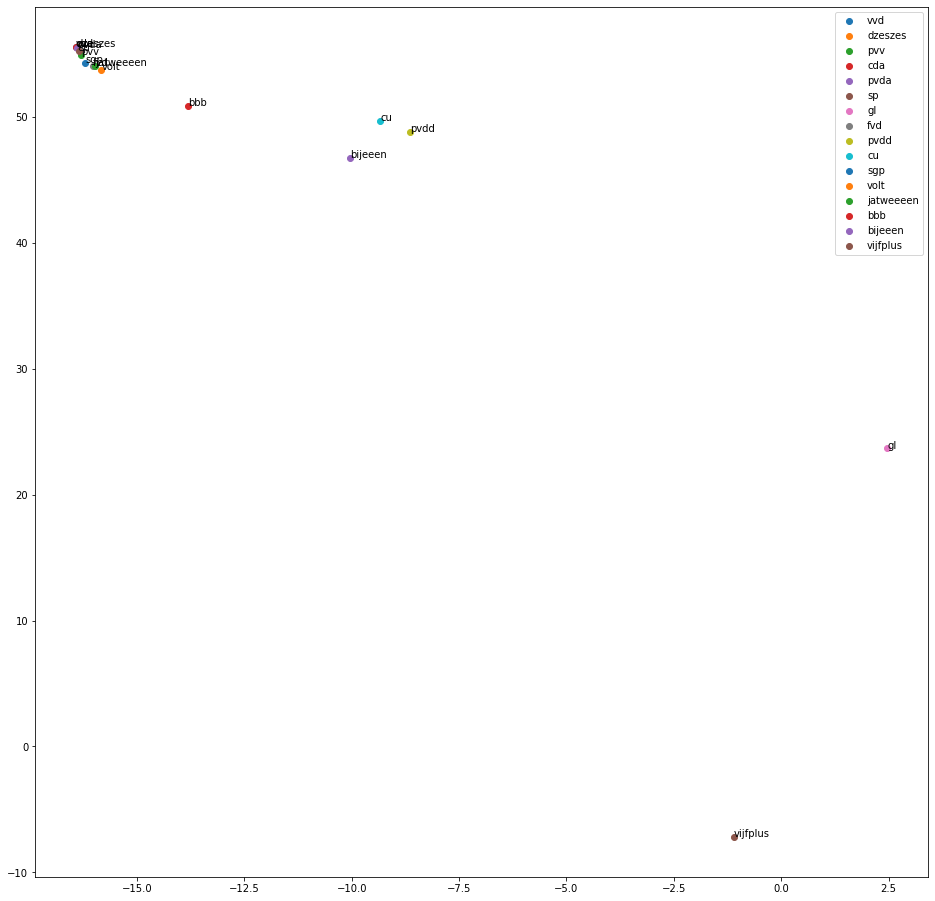

In [40]:
plot_function(x_vals, y_vals, labels, parties)

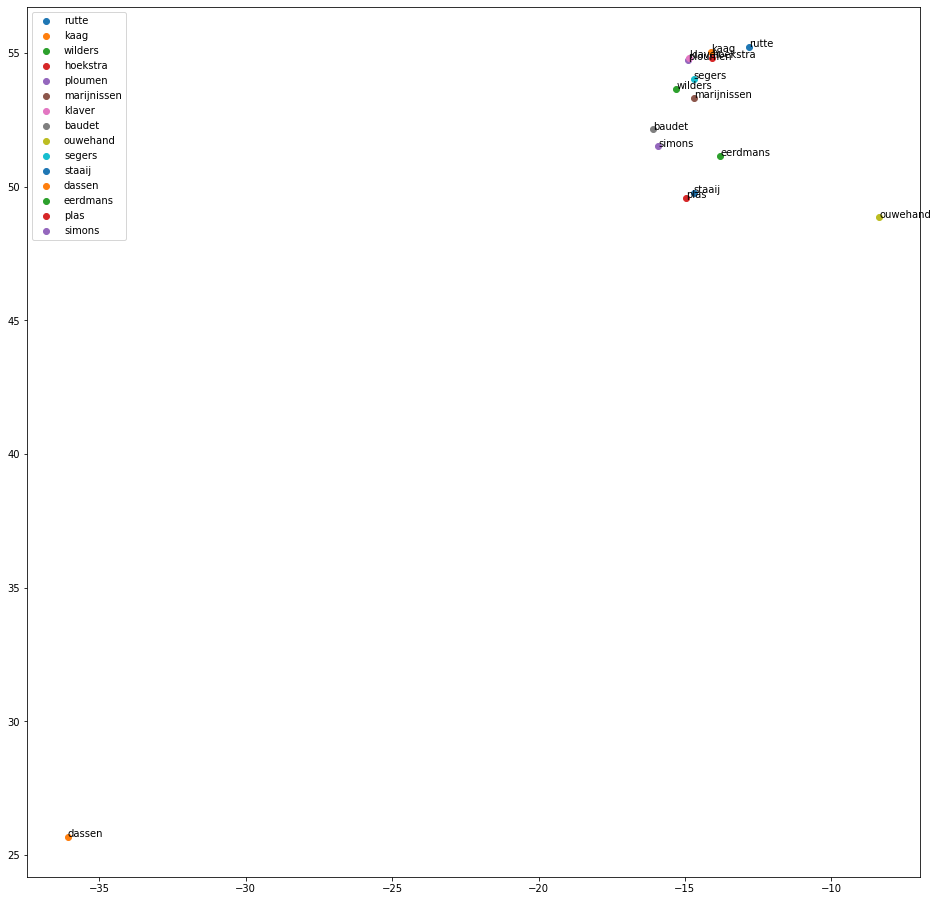

In [41]:
plot_function(x_vals, y_vals, labels, pols)

In [42]:
x_vals, y_vals, labels = tsne_analysis(df_Volkskrant)

Frame shape:  (3749, 5)
Corpus length:  3749


100%|██████████| 3749/3749 [00:09<00:00, 392.96it/s]
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25167 samples in 0.003s...
[t-SNE] Computed neighbors for 25167 samples in 18.853s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25167
[t-SNE] Computed conditional probabilities for sample 2000 / 25167
[t-SNE] Computed conditional probabilities for sample 3000 / 25167
[t-SNE] Computed conditional probabilities for sample 4000 / 25167
[t-SNE] Computed conditional probabilities for sample 5000 / 25167
[t-SNE] Computed conditional probabilities for sample 6000 / 25167
[t-SNE] Computed conditional probabilities for sample 7000 / 25167
[t-SNE] Computed conditional probabilities for sample 8000 / 25167
[t-SNE] Computed conditional probabilities for sample 9000 / 25167
[t-SNE] Computed conditional probabilities for sample 10000 / 25167
[t-SNE] Computed conditional probabilities for sample 11000 / 25167
[t-SNE] Computed conditional probabilities for sample 12000 / 25167
[t-SNE] Computed conditional probabilities for sa

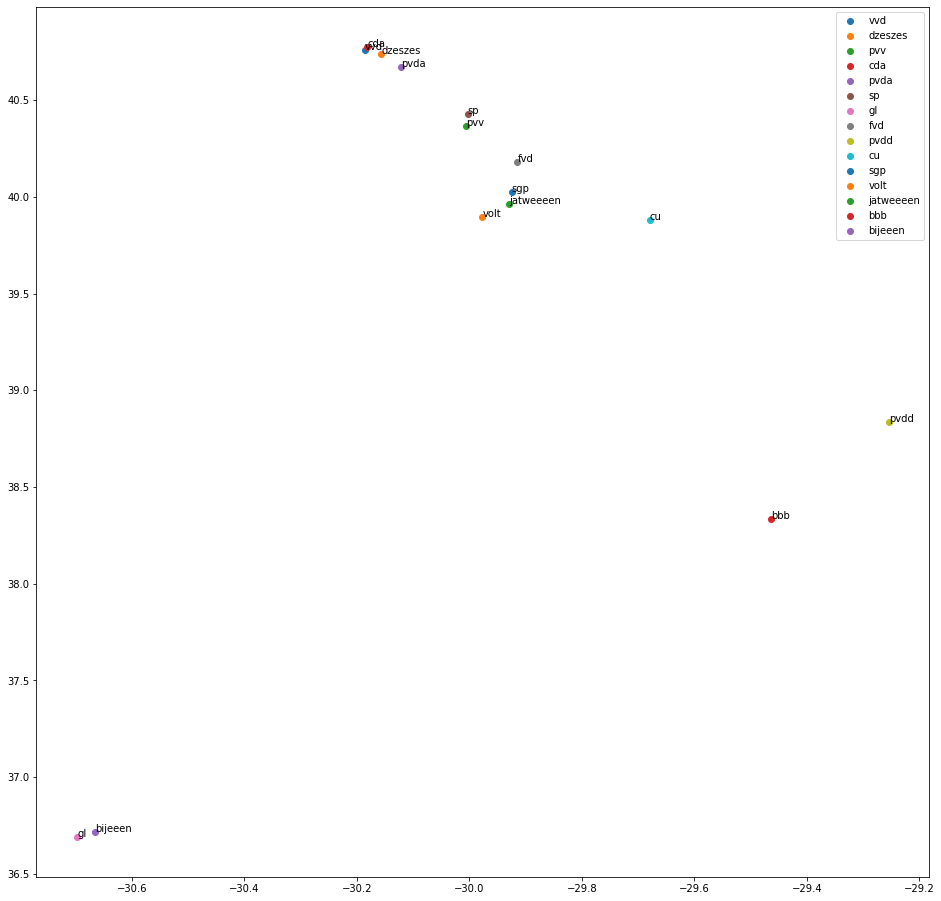

In [44]:
parties = ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
            'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen']
plot_function(x_vals, y_vals, labels, parties)

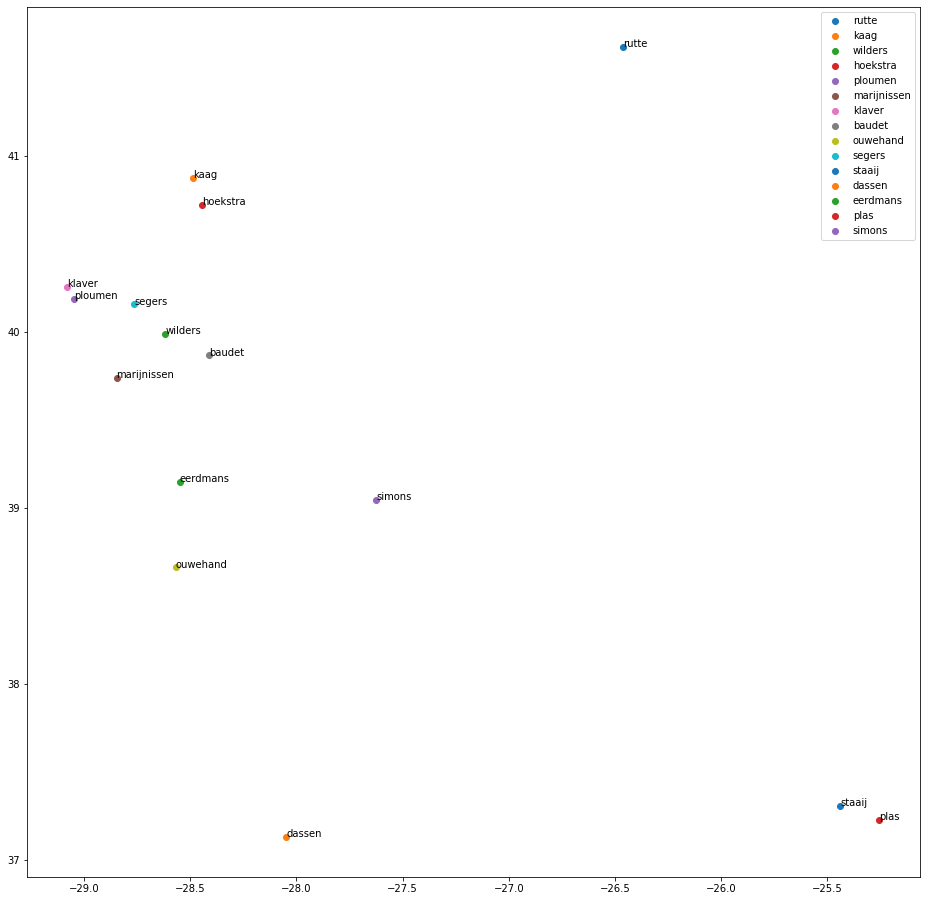

In [45]:
plot_function(x_vals, y_vals, labels, pols)